In [1]:
import numpy as onp
import tensorflow as tf

from neural_tangents import stax

from functools import partial
from tqdm import tqdm
# Attacking
from cleverhans.utils import clip_eta, one_hot

# Plotting
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import *

sns.set_style(style='white')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

"""
diag_reg:
    a scalar representing the strength of the diagonal regularization for
    `k_train_train`, i.e. computing `k_train_train + diag_reg * I` during
    Cholesky factorization or eigendecomposition.
"""
diag_reg = 1e-5

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
tf.keras.backend.set_floatx('float64')

# data

In [2]:
DATASET = 'mnist'
class_num   = 10
image_shape = None

train_size = 10000
valid_size = 1024
test_size  = 10000

if DATASET =='mnist':
    image_shape = (28, 28)
elif DATASET == 'cifar10':
    image_shape = (32, 32, 3)

In [3]:
x_train_all, y_train_all, x_test_all, y_test_all = tuple(onp.array(x) for x in get_dataset(DATASET, None, None, 
                                                                                  do_flatten_and_normalize=False))

In [4]:
# shuffle
seed = 0
x_train_all, y_train_all = shaffle(x_train_all, y_train_all, seed)

In [5]:
# down sample
x_train = x_train_all[:train_size]
y_train = y_train_all[:train_size]

x_valid = x_train_all[train_size:train_size+valid_size]
y_valid = y_train_all[train_size:train_size+valid_size]

x_test = x_test_all[:test_size]
y_test = y_test_all[:test_size]

In [6]:
# x_train, x_valid, x_test = x_train.reshape((-1, *image_shape)), x_valid.reshape((-1, *image_shape)), x_test.reshape((-1, *image_shape))

# finite width

In [7]:
layers = tf.keras.layers

In [8]:
batch = 64
width = 32

In [11]:
width_tick = [2**i for i in range(7)]

In [10]:
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
valid_ds = valid_ds.shuffle(5000)
valid_ds = valid_ds.batch(batch)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(20000)
train_ds = train_ds.batch(batch)

In [29]:
# for multi in width_tick:
#     img_input = layers.Input(shape=(28*28,))
#     x = layers.Dense(width * multi)(img_input)
#     x = layers.ReLU()(x)
#     x = layers.Dense(width * multi)(x)
#     x = layers.ReLU()(x)
#     x = layers.Dense(width * multi)(x)
#     x = layers.ReLU()(x)
#     x = layers.Dense(width * multi)(x)
#     x = layers.ReLU()(x)
#     x = layers.Dense(width * multi)(x)
#     x = layers.ReLU()(x)
#     x = layers.Dense(width * multi)(x)
#     x = layers.ReLU()(x)
#     x = layers.Dense(width * multi)(x)
#     x = layers.ReLU()(x)
#     x = layers.Dense(width * multi)(x)
#     x = layers.ReLU()(x)
#     x = layers.Dense(width * multi)(x)
#     x = layers.Flatten()(x)
#     out = layers.Dense(10)(x)
    
#     model = tf.keras.Model(img_input, out)
#     model.summary()
#     model.compile(optimizer='sgd',
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
#     model.fit(x=train_ds, validation_data=valid_ds, epochs=50)
#     model.save_weights('./dense_10_weights/dense_10_with_multi_%s'%(str(multi)))

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_110 (Dense)            (None, 32)                25120     
_________________________________________________________________
re_lu_88 (ReLU)              (None, 32)                0         
_________________________________________________________________
dense_111 (Dense)            (None, 32)                1056      
_________________________________________________________________
re_lu_89 (ReLU)              (None, 32)                0         
_________________________________________________________________
dense_112 (Dense)            (None, 32)                1056      
_________________________________________________________________
re_lu_90 (ReLU)              (None, 32)              

157/157 [==============================] - 0s 2ms/step - loss: 0.1452 - accuracy: 0.9562 - val_loss: 0.3285 - val_accuracy: 0.9199
Epoch 24/50
157/157 [==============================] - 0s 2ms/step - loss: 0.1299 - accuracy: 0.9609 - val_loss: 0.2865 - val_accuracy: 0.9209
Epoch 25/50
157/157 [==============================] - 0s 2ms/step - loss: 0.1241 - accuracy: 0.9628 - val_loss: 0.2673 - val_accuracy: 0.9307
Epoch 26/50
157/157 [==============================] - 0s 2ms/step - loss: 0.1133 - accuracy: 0.9670 - val_loss: 0.2734 - val_accuracy: 0.9326
Epoch 27/50
157/157 [==============================] - 0s 2ms/step - loss: 0.1032 - accuracy: 0.9710 - val_loss: 0.4764 - val_accuracy: 0.8828
Epoch 28/50
157/157 [==============================] - 0s 2ms/step - loss: 0.1071 - accuracy: 0.9684 - val_loss: 0.2597 - val_accuracy: 0.9326
Epoch 29/50
157/157 [==============================] - 0s 2ms/step - loss: 0.0923 - accuracy: 0.9737 - val_loss: 0.8089 - val_accuracy: 0.8164
Epoch 30/50

Epoch 1/50
157/157 [==============================] - 1s 8ms/step - loss: 2.2937 - accuracy: 0.1690 - val_loss: 2.2840 - val_accuracy: 0.2373
Epoch 2/50
157/157 [==============================] - 0s 2ms/step - loss: 2.2594 - accuracy: 0.3405 - val_loss: 2.2247 - val_accuracy: 0.3799
Epoch 3/50
157/157 [==============================] - 2s 12ms/step - loss: 2.0382 - accuracy: 0.4519 - val_loss: 1.6499 - val_accuracy: 0.5049
Epoch 4/50
157/157 [==============================] - 0s 2ms/step - loss: 1.1436 - accuracy: 0.6504 - val_loss: 0.8184 - val_accuracy: 0.7432
Epoch 5/50
157/157 [==============================] - 0s 2ms/step - loss: 0.7158 - accuracy: 0.7722 - val_loss: 0.6477 - val_accuracy: 0.7988
Epoch 6/50
157/157 [==============================] - 0s 2ms/step - loss: 0.5153 - accuracy: 0.8465 - val_loss: 0.6478 - val_accuracy: 0.7910
Epoch 7/50
157/157 [==============================] - 0s 2ms/step - loss: 0.4206 - accuracy: 0.8713 - val_loss: 0.4944 - val_accuracy: 0.8428
Epoch

Epoch 1/50
157/157 [==============================] - 2s 10ms/step - loss: 2.2825 - accuracy: 0.2333 - val_loss: 2.2565 - val_accuracy: 0.4902
Epoch 2/50
157/157 [==============================] - 0s 3ms/step - loss: 2.1509 - accuracy: 0.4839 - val_loss: 1.9040 - val_accuracy: 0.5361
Epoch 3/50
157/157 [==============================] - 2s 13ms/step - loss: 1.3109 - accuracy: 0.6573 - val_loss: 0.7944 - val_accuracy: 0.7412
Epoch 4/50
157/157 [==============================] - 0s 3ms/step - loss: 0.6649 - accuracy: 0.7937 - val_loss: 0.6146 - val_accuracy: 0.8018
Epoch 5/50
157/157 [==============================] - 0s 3ms/step - loss: 0.4943 - accuracy: 0.8489 - val_loss: 1.2339 - val_accuracy: 0.5664
Epoch 6/50
157/157 [==============================] - 0s 3ms/step - loss: 0.3932 - accuracy: 0.8826 - val_loss: 0.5142 - val_accuracy: 0.8418
Epoch 7/50
157/157 [==============================] - 0s 3ms/step - loss: 0.3293 - accuracy: 0.8973 - val_loss: 0.7334 - val_accuracy: 0.7793
Epoc

Epoch 1/50
157/157 [==============================] - 1s 9ms/step - loss: 2.2783 - accuracy: 0.3117 - val_loss: 2.2434 - val_accuracy: 0.4375
Epoch 2/50
157/157 [==============================] - 1s 3ms/step - loss: 2.0847 - accuracy: 0.4940 - val_loss: 1.7426 - val_accuracy: 0.5322
Epoch 3/50
157/157 [==============================] - 2s 13ms/step - loss: 1.1281 - accuracy: 0.6858 - val_loss: 0.7109 - val_accuracy: 0.8115
Epoch 4/50
157/157 [==============================] - 1s 3ms/step - loss: 0.5845 - accuracy: 0.8234 - val_loss: 0.5029 - val_accuracy: 0.8389
Epoch 5/50
157/157 [==============================] - 1s 3ms/step - loss: 0.4031 - accuracy: 0.8787 - val_loss: 0.4570 - val_accuracy: 0.8691
Epoch 6/50
157/157 [==============================] - 1s 3ms/step - loss: 0.3404 - accuracy: 0.8979 - val_loss: 0.3679 - val_accuracy: 0.8916
Epoch 7/50
157/157 [==============================] - 1s 3ms/step - loss: 0.2842 - accuracy: 0.9135 - val_loss: 0.3150 - val_accuracy: 0.9072
Epoch

157/157 [==============================] - 2s 15ms/step - loss: 2.2653 - accuracy: 0.2859 - val_loss: 2.2027 - val_accuracy: 0.5049
Epoch 2/50
157/157 [==============================] - 1s 7ms/step - loss: 1.8275 - accuracy: 0.5903 - val_loss: 1.1572 - val_accuracy: 0.6289
Epoch 3/50
157/157 [==============================] - 3s 17ms/step - loss: 0.7908 - accuracy: 0.7653 - val_loss: 0.9071 - val_accuracy: 0.6836
Epoch 4/50
157/157 [==============================] - 1s 7ms/step - loss: 0.4946 - accuracy: 0.8516 - val_loss: 0.4348 - val_accuracy: 0.8672
Epoch 5/50
157/157 [==============================] - 1s 7ms/step - loss: 0.3763 - accuracy: 0.8866 - val_loss: 0.3917 - val_accuracy: 0.8838
Epoch 6/50
157/157 [==============================] - 1s 7ms/step - loss: 0.3018 - accuracy: 0.9097 - val_loss: 0.3094 - val_accuracy: 0.9131
Epoch 7/50
157/157 [==============================] - 1s 7ms/step - loss: 0.2489 - accuracy: 0.9258 - val_loss: 0.4694 - val_accuracy: 0.8691
Epoch 8/50
157/

In [11]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [16]:
for multi in width_tick:
    img_input = layers.Input(shape=(28*28,))
    x = layers.Dense(width * multi)(img_input)
    x = layers.ReLU()(x)
    x = layers.Dense(width * multi)(x)
    x = layers.ReLU()(x)
    x = layers.Dense(width * multi)(x)
    x = layers.ReLU()(x)
    x = layers.Dense(width * multi)(x)
    x = layers.ReLU()(x)
    x = layers.Dense(width * multi)(x)
    x = layers.ReLU()(x)
    x = layers.Dense(width * multi)(x)
    x = layers.ReLU()(x)
    x = layers.Dense(width * multi)(x)
    x = layers.ReLU()(x)
    x = layers.Dense(width * multi)(x)
    x = layers.ReLU()(x)
    x = layers.Dense(width * multi)(x)
    x = layers.Flatten()(x)
    out = layers.Dense(10)(x)
    
    model = tf.keras.Model(img_input, out)
    model.load_weights('./dense_10_weights/dense_10_with_multi_%s'%(str(multi)))
    
    @tf.function
    def get_cross_entropy_hessian(y, x):
        y_pred = model(x)
        cross_en = loss(y, y_pred)
        return tf.hessians(cross_en, x)

    hessians = 0
    for x, y in zip(tqdm(x_test), y_test):
        x_tensor = tf.convert_to_tensor(x.reshape(-1, 28*28))
        y_tensor = tf.convert_to_tensor(y.reshape(-1, class_num))
        hs = get_cross_entropy_hessian(y_tensor, x_tensor)
        hs = tf.reshape(hs, (784, 784))
        hessians += hs
        
    onp.save('./dense_10_hessians/dense_10_hessians_with_multi_%s'%(str(multi)), hessians)

100%|██████████| 10000/10000 [56:53<00:00,  2.93it/s]

100%|██████████| 10000/10000 [58:11<00:00,  2.86it/s]

100%|██████████| 10000/10000 [57:48<00:00,  2.88it/s]

100%|██████████| 10000/10000 [1:13:34<00:00,  2.27it/s]

100%|██████████| 10000/10000 [1:14:33<00:00,  2.24it/s]

100%|██████████| 10000/10000 [1:14:34<00:00,  2.23it/s]

100%|██████████| 10000/10000 [1:49:31<00:00,  1.52it/s]


In [13]:
hessian = {
    i : onp.load('./dense_10_hessians/dense_10_hessians_with_multi_%s.npy'%(str(i))) for i in width_tick
}

In [17]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return onp.allclose(a, a.T, rtol=rtol, atol=atol)

In [38]:
val[::-1].shape

(784,)

In [33]:
import paper_plot as pt

In [74]:
vals = []
line_lables = []
for k, v in hessian.items():
    val, vec = onp.linalg.eigh(v)
    vals.append(val[:-21:-1])
    line_lables.append("width = %s"%(str(k*width)))
    

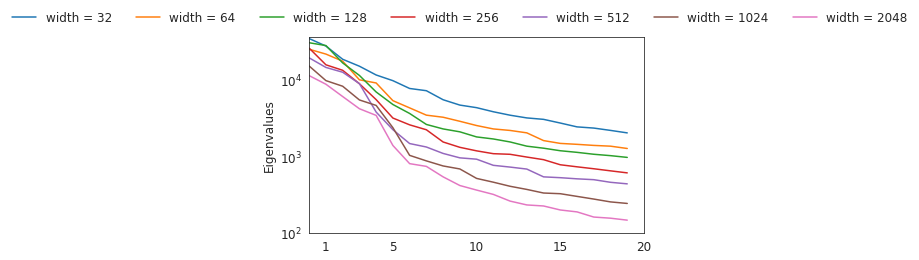

In [90]:
pt.lines(range(20), vals).y_label('Eigenvalues').data_labels(line_lables).show_legend() \
  .legend_out().y_min(100).y_scale('log').x_ticks([1, 5, 10, 15, 20]).draw().save_as_pdf('fig-example')

# infinite width

In [11]:
batch_inf_kernel_fn = nt.batch(kernel_fn, batch_size=256, store_on_device=False)

kernel_train_m = batch_inf_kernel_fn(x_train_down, None, 'ntk')

eigval_inf, eigv_inf = np.linalg.eigh(kernel_train_m + np.eye(train_size)*diag_reg)

/home/nthudatalab1/yurong/ntk-env/lib/python3.6/site-packages/neural_tangents/utils/batch.py:616: UserWarning: Batch size is reduced from requested 256 to effective 64 to fit the dataset.
  'fit the dataset.' % (batch_size, n2_batch_size))


In [30]:
def plt_samples(arr, attack_type, layer):
    fig, axs = plt.subplots(2, 4, figsize=(6, 3), sharex=True)
    for row, ax in enumerate(axs):
        for idx, a in enumerate(ax):
            img = arr[idx + row*4].reshape(image_shape)
            a.axis('off')
            a.xaxis.set_visible(False)
            a.yaxis.set_visible(False)
            a.imshow(img, cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

In [31]:
def save_samples(arr, attack_type, layer):
    fig, axs = plt.subplots(2, 4, figsize=(6, 3), sharex=True)
    for row, ax in enumerate(axs):
        for idx, a in enumerate(ax):
            img = arr[idx + row*4].reshape(image_shape)
            a.axis('off')
            a.xaxis.set_visible(False)
            a.yaxis.set_visible(False)
            a.imshow(img, cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.savefig("./fig-%s-untargeted/%s_layer_%d.png"%(DATASET ,attack_type, layer+1), dpi=150)
    plt.show()